# Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

%load_ext autoreload
%autoreload 2
%aimport -tensorflow

!pip install -q plantcv

# Image IO and Displaying

In [41]:
from src.post_process import post_process
from src.visual_tools import *
import matplotlib.pyplot as plt
from skimage import morphology, io
from skimage import img_as_ubyte as as_ubyte

def run_analysis(input_dir, process_args, save_to_dir=None, DEBUG=False):
    imgs = np.array([])
    img_paths = np.array([])
    for fname in np.sort(os.listdir(input_dir)):
        if fname.endswith('.png') and np.char.find(fname, 'trace') == -1:
            path = os.path.join(input_dir, fname)
            img_paths = np.append(img_paths, path)
            img = io.imread(path)
            if len(img.shape) > 2:
                img = img[:,:,0]
                
            if len(imgs) == 0:
                imgs = img
            else:
                imgs = np.dstack((imgs,img))
    
    data = post_process(imgs, **process_args)
    
    if DEBUG:
        trace_dir = img_paths[0].split('/predict/')[0]
        trace_path = os.path.join(trace_dir, 'trace.png')

        trace = io.imread(trace_path)
        print('plotting')
        fig, axes = plt.subplots(2, 4, figsize=(15,8))

        for ax in axes.flatten():
            ax.set_axis_off()

        sub_plot(axes[0,0], data['compiled'], title='Min (logical or) Combined Image')
        sub_plot(axes[0,1], data['double_thresh'], title='Double Thresholded Combined Image')
        sub_plot(axes[0,2], data['dilated'], title='Dilated')
        sub_plot(axes[0,3], data['closed'], title='Fill Holes')
        
        sub_plot(axes[1,0], data['skeleton'], title='Double Threshold Skeleton')
        sub_plot(axes[1,1], data['pruned_skeleton'], title='Pruned Skeleton')
        sub_plot(axes[1,3], trace, title='Hand Tracing')

        fig.tight_layout()
        plt.show()
        plt.close()

    if save_to_dir is not None:
        io.imsave(os.path.join(save_to_dir,f'compiled.png'), 255 * data['pruned_skeleton'])
        '''
        if not os.path.isdir(save_to_dir):
            os.mkdir(save_to_dir)
        io.imsave(os.path.join(save_dir,'1_combine.png'), data['compiled'])
        io.imsave(os.path.join(save_dir,'2_thresh.png'),  as_ubyte(data['double_thresh']))
        io.imsave(os.path.join(save_dir,'3_dilate.png'),  as_ubyte(data['dilated']))
        io.imsave(os.path.join(save_dir,'4_fill.png'),    as_ubyte(data['closed']))
        io.imsave(os.path.join(save_dir,'5_skel.png'),    as_ubyte(data['skeleton']))
        io.imsave(os.path.join(save_dir,'6_pruned_skel.png'), 255 * data['pruned_skeleton'])
        '''

    return data['pruned_skeleton']

In [42]:
from src.post_process import post_process
from src.visual_tools import *
import matplotlib.pyplot as plt
from skimage import morphology, io
from skimage import img_as_ubyte as as_ubyte

def run_analysis_1ch(input_dir, process_args, save_dir=None, DEBUG=False):
    imgs = []
    for fname in np.sort(os.listdir(input_dir)):
        if fname.endswith('.png') and np.char.find(fname, 'trace') == -1:
            path = os.path.join(input_dir, fname)
            img = io.imread(path)
            if len(img.shape) > 2:
                img = img[:,:,0]
            imgs.append((img,path))
    print(len(imgs))

    for img in imgs:
        print(img[0].shape, img[1])
        data = post_process(img[0], **process_args)

        if DEBUG:
            trace_dir = img[1].split('/predict/')[0]
            trace_path = os.path.join(trace_dir, 'trace.png')

            trace = io.imread(trace_path)
            print('plotting')
            fig, axes = plt.subplots(2, 4, figsize=(15,8))

            for ax in axes.flatten():
                ax.set_axis_off()

            sub_plot(axes[0,0], data['compiled'], title='Min (logical or) Combined Image')
            sub_plot(axes[0,1], data['double_thresh'], title='Double Thresholded Combined Image')
            sub_plot(axes[0,2], data['dilated'], title='Dilated')
            sub_plot(axes[0,3], data['closed'], title='Fill Holes')

            sub_plot(axes[1,0], data['skeleton'], title='Double Threshold Skeleton')
            sub_plot(axes[1,1], data['pruned_skeleton'], title='Pruned Skeleton')
            sub_plot(axes[1,3], trace, title='Hand Tracing')

            fig.tight_layout()
            plt.show()
            plt.close()

        if save_dir is not None:
            fname = (img[1].split('/')[-1])[:-4]
            if not os.path.isdir(save_dir):
                os.mkdir(save_dir)
            io.imsave(os.path.join(save_dir,f'{fname}.png'), 255 * data['pruned_skeleton'])    
            '''
            img_save_dir = os.path.join(save_dir,fname)
            print(img_save_dir)
            io.imsave(os.path.join(img_save_dir,'1_combine.png'), data['compiled'])
            io.imsave(os.path.join(img_save_dir,'2_thresh.png'),  as_ubyte(data['double_thresh']))
            io.imsave(os.path.join(img_save_dir,'3_dilate.png'),  as_ubyte(data['dilated']))
            io.imsave(os.path.join(img_save_dir,'4_fill.png'),    as_ubyte(data['closed']))
            io.imsave(os.path.join(img_save_dir,'5_skel.png'),    as_ubyte(data['skeleton']))
            io.imsave(os.path.join(img_save_dir,'6_pruned_skel.png'), 255 * data['pruned_skeleton'])
            '''

# Doing Image Compilation

In [2]:
import os
from skimage import io, morphology
import numpy as np
%load_ext autoreload
%autoreload 2

hours = ['1hr2745',
            '1hr2741',
            '1hr2753',
            '1hr2761',
            '1hr2789',
            '2hr2312',
            '2hr2314',
            '2hr2317',
            '2hr2331',
            '2hr2349',
            '2hr2354',
            '2hr2356',
            '2hr2364',
            '4hr2413',
            '4hr2414',
            '4hr2434',
            '4hr2436',
            '4hr2465',
            '4hr2495',
            '4hr2507',
            '10hr2127',
            '10hr2136',
            '10hr2144',
            '10hr2153',
            '10hr2155',
            '10hr2159',
            '10hr2400',
            '10hr2405',
            '10hr2429']

In [ ]:
skel_dir = f'../data/test_all/results 03-24 (2 dilations)'

for entry in hours:
    print(entry)
    hour = entry.split('hr')[0] + 'HR'
    fov = entry.split('hr')[-1]
    fov_dir = f'../data/test_all/{hour}/{fov}'
#    fov_dir = f'../data/test Pt/{entry}'
    input_dir = os.path.join(fov_dir, 'predict')
    save_dir = os.path.join(fov_dir, 'results/tracings/')
#    save_dir = None
        
    args = {
        'compilation': 'min',
        'n_dilations': 2,
        'liberal_thresh': 200,
        'conservative_thresh': 160,
        'invert_double_thresh': True,
        'out_dict': True
    }
    
    pruned_skel = run_analysis_1ch(input_dir, save_dir=save_dir, process_args=args, DEBUG=False)
    
    '''
    if skel_dir is not None:
        io.imsave(os.path.join(skel_dir,f'{entry}.png'), 255 * pruned_skel)
    print(os.path.join(fov_dir, 'trace.png'))
    try:
        trace = io.imread(os.path.join(fov_dir, 'trace.png'))
    except FileNotFoundError:
        trace = io.imread(os.path.join(fov_dir, 'trace.tif'))
        
    if skel_dir is not None:
        io.imsave(os.path.join(skel_dir,f'{entry}_trace.png'), trace)
    '''

In [ ]:
fig, axes = plt.subplots(len(hours), 3, figsize=(13,4 * len(hours)))
    
for ax in axes.flatten():
    ax.set_axis_off()

for ind, entry in enumerate(hours):
    print(entry)
    hour = entry.split('hr')[0] + 'HR'
    fov = entry.split('hr')[-1]
    fov_dir = f'../data/test_all/{hour}/{fov}'
    
    trace_path = os.path.join(fov_dir, 'trace.png')
    trace = io.imread(trace_path)
    
    skel_path = os.path.join(skel_dir, f'{entry}.png')
    skel = io.imread(skel_path)
    
    skel_no_fill_path = os.path.join(f'../data/test_all/results 03-21', f'{entry}.png')
    skel_no_fill = io.imread(skel_no_fill_path)
    
    sub_plot(axes[ind,0], trace, title=f'{entry}\nHand Tracing', title_color='w')
    sub_plot(axes[ind,1], 255-skel, title='Skeleton With Closing', title_color='w')
    sub_plot(axes[ind,2], 255-skel_no_fill, title='Skeleton Without Closing', title_color='w')

fig.tight_layout()
print('Saving Fig')
fig.savefig('big.png', facecolor='black', bbox_inches='tight', dpi=100)
plt.close()

In [96]:
def generate_markdown(hour, fov, slides, tag=None):
    header = f'## {hour.lower()}{fov}'
    img_tag = f'![bg height:600px]'
    if tag is None:
        tag = [''] * len(slides)
    #slides = ['slide1.png','slide2.png','stack2thresh.png','thresh2stack_double.png','thresh2stack_stack.png']
    #tag = ['','','### Combine First, Threshold After','### Threshold First - Double Threshold','### Threshold First - Combine']
    md_str = ''
    for ind, slide in enumerate(slides):
        md_str += header
        md_str += '\n'
        md_str += tag[ind]
        md_str += '\n\n'
        md_str += img_tag
        md_str += '('
        md_str += os.path.join(hour.lower(),fov,'slides',slide)
        md_str += ')'
        md_str += '\n\n---\n\n'

    return md_str

1hr2745


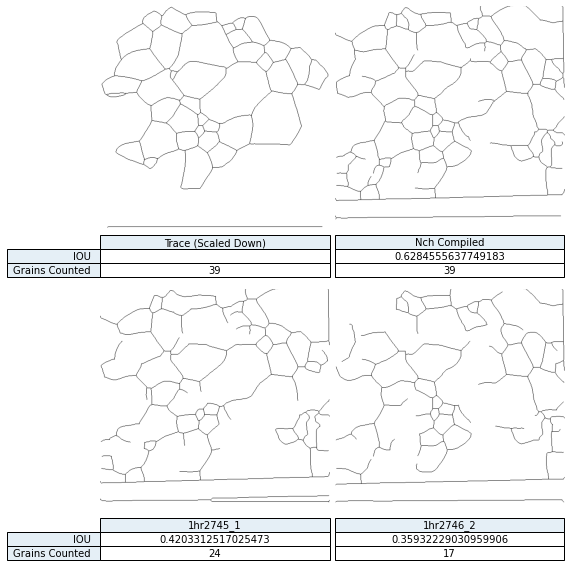

1hr2741


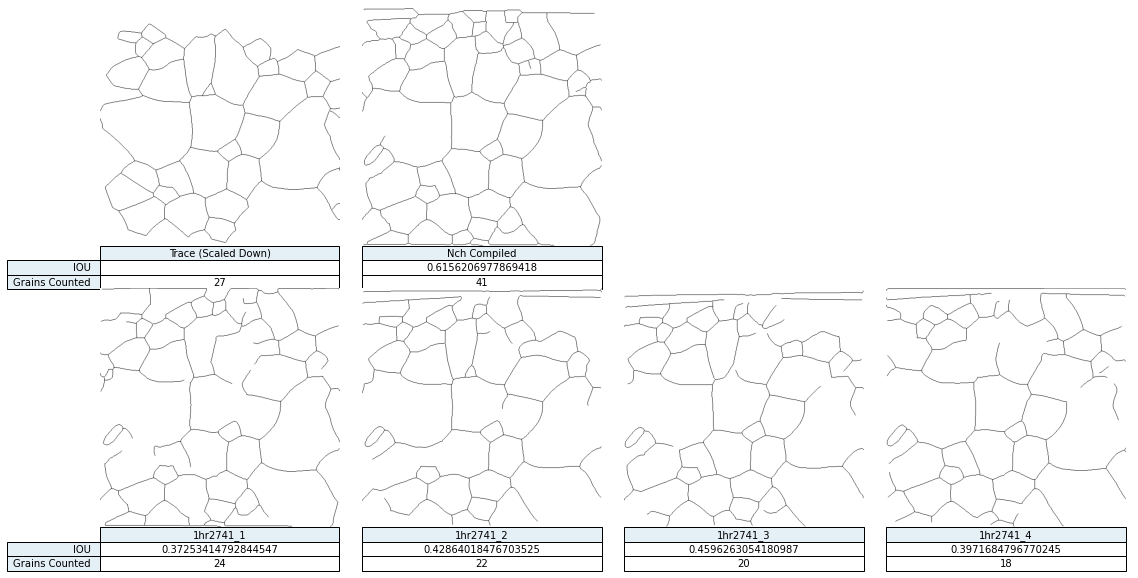

1hr2753


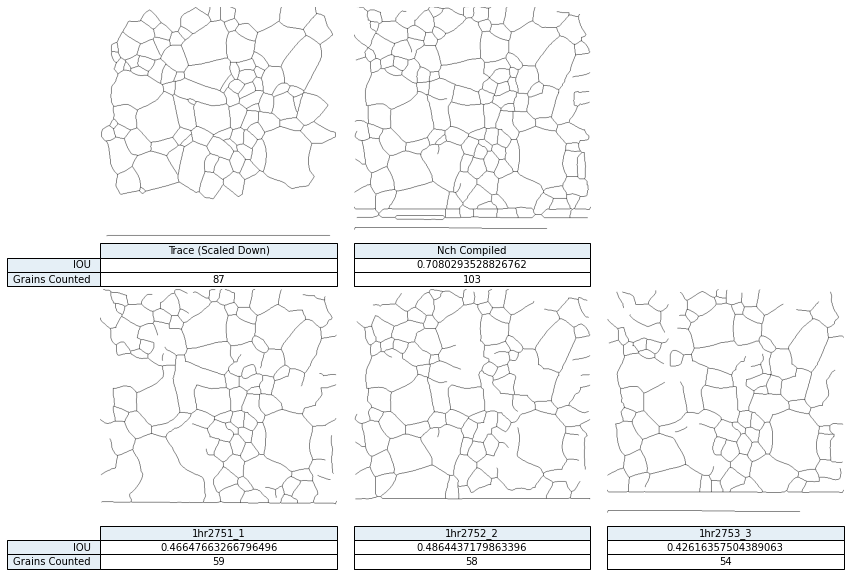

1hr2761


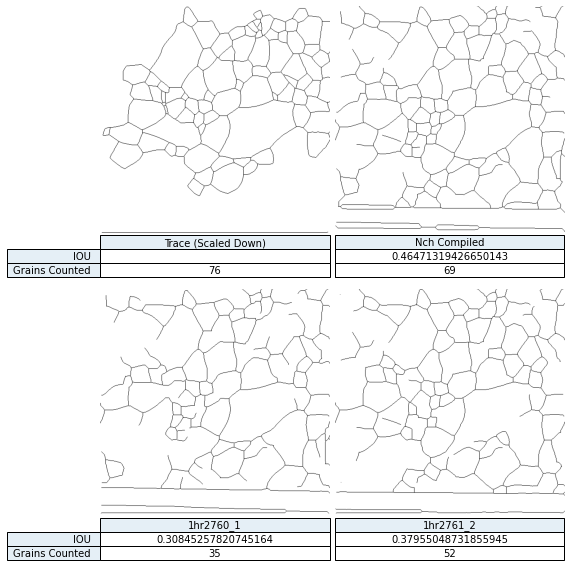

1hr2789


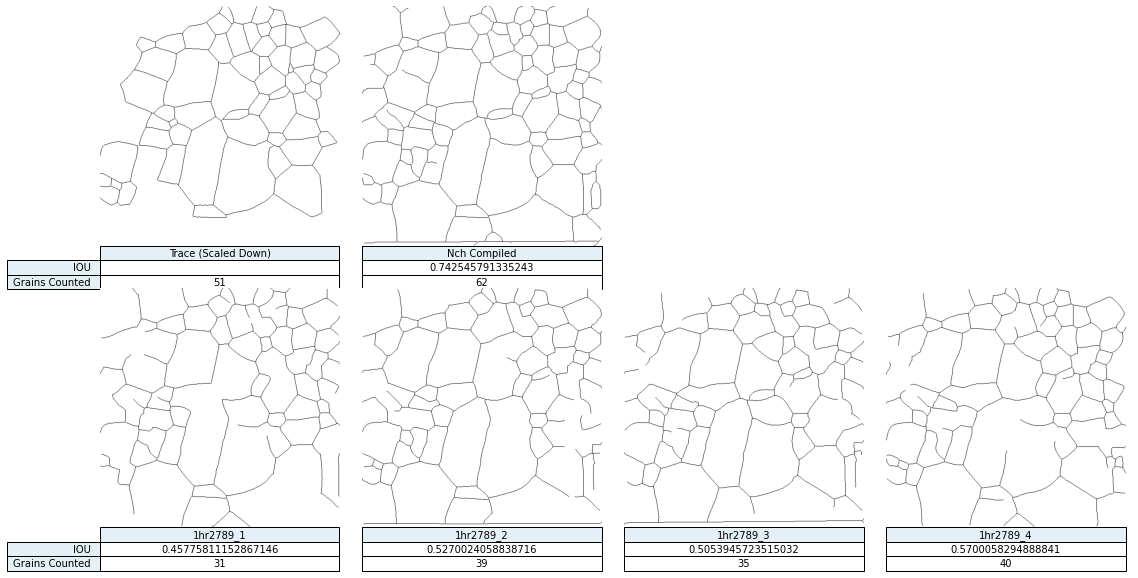

2hr2312


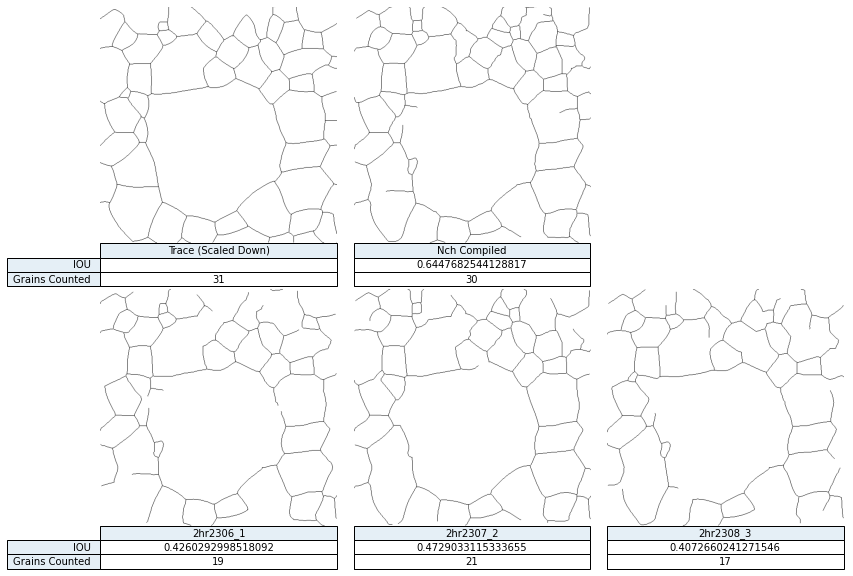

2hr2314


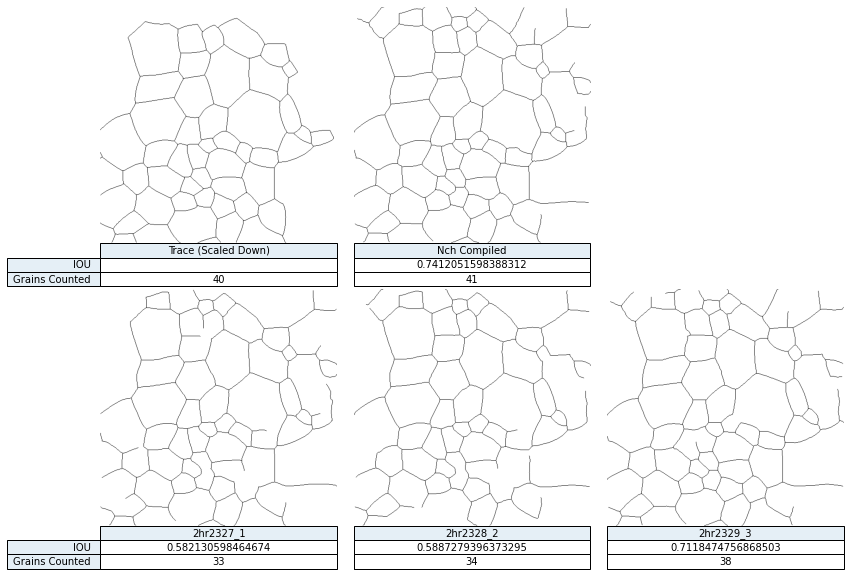

2hr2317


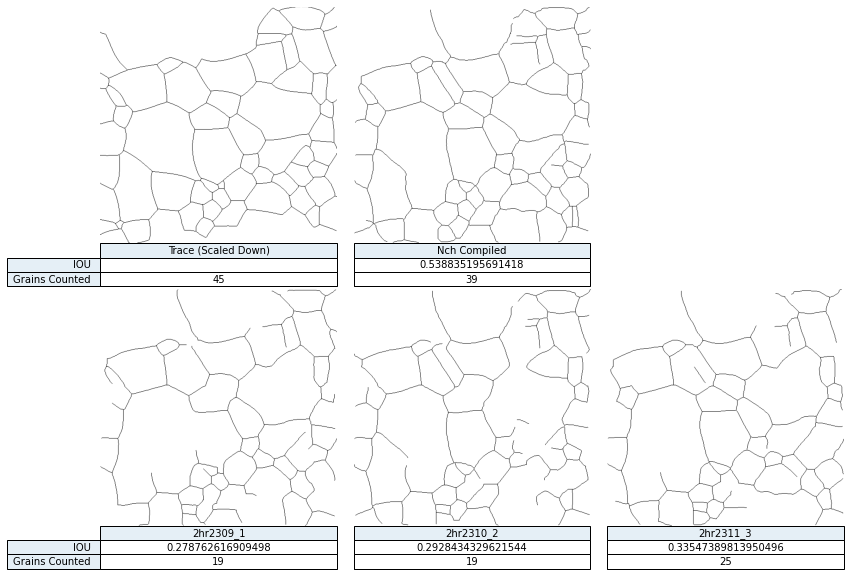

2hr2331


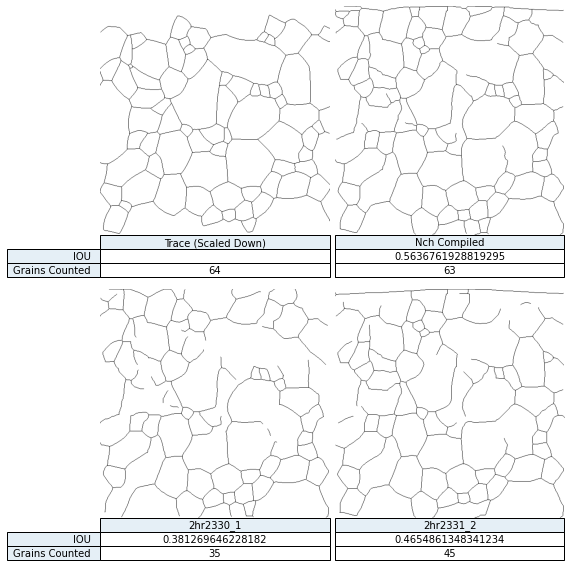

2hr2349


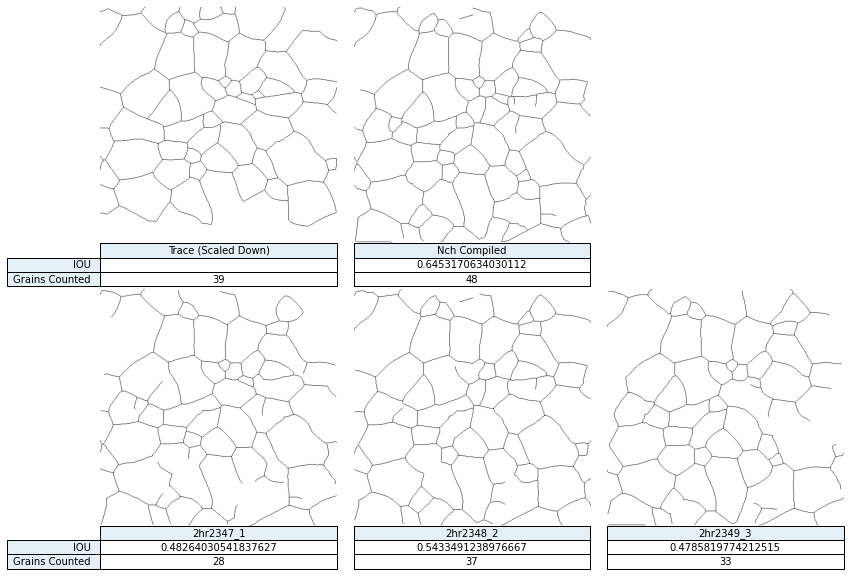

2hr2354


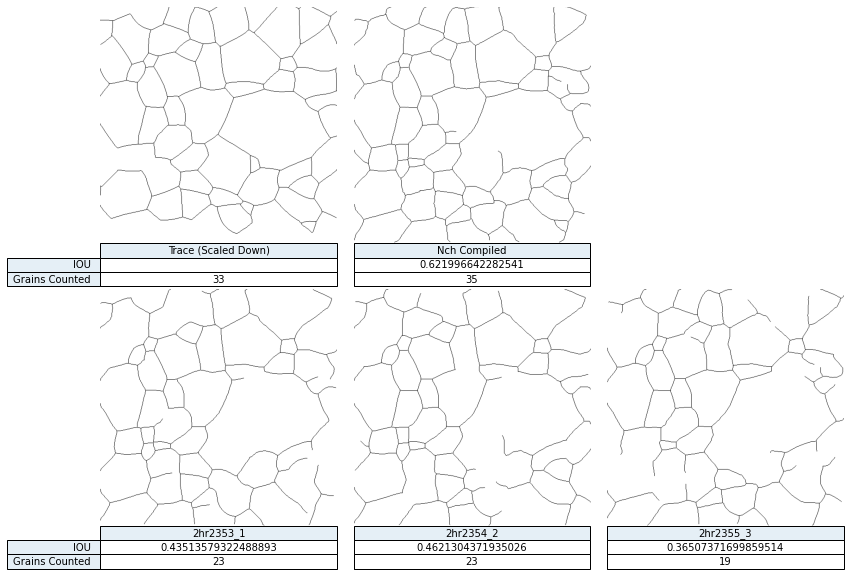

2hr2356


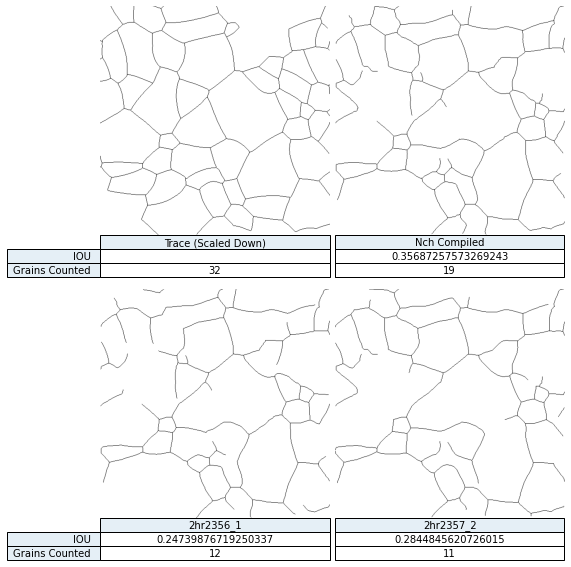

2hr2364


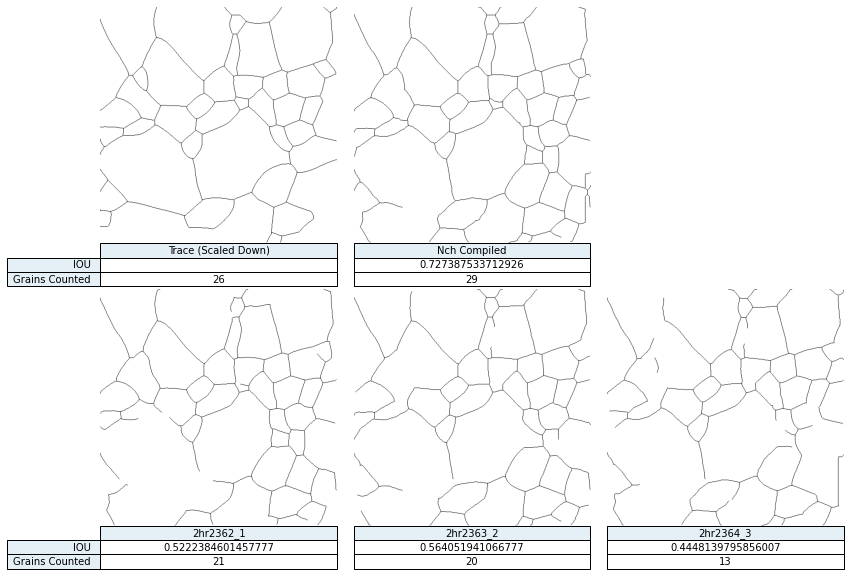

4hr2413
4hr2414


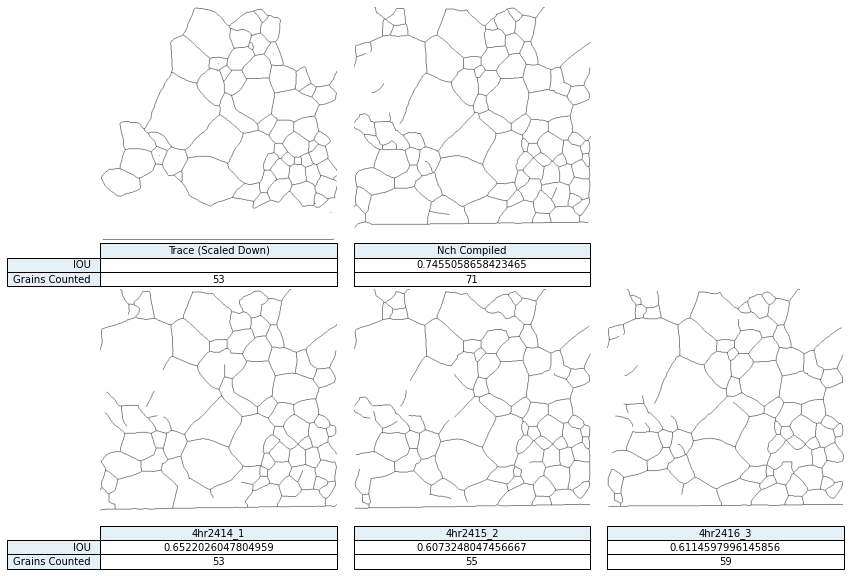

4hr2434


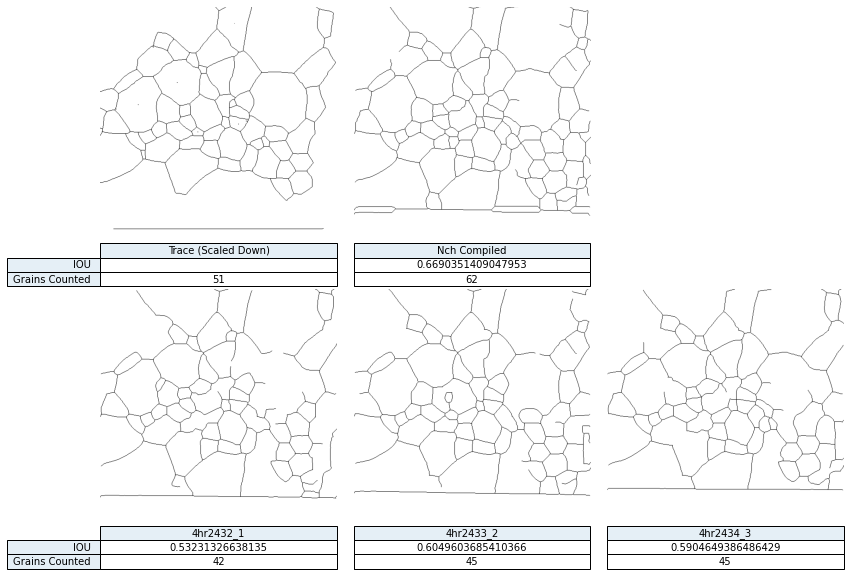

4hr2436


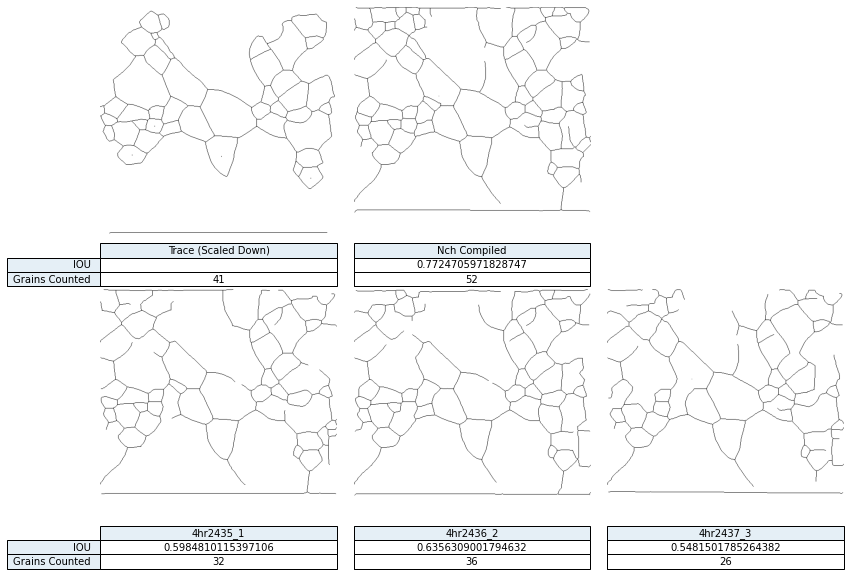

4hr2465


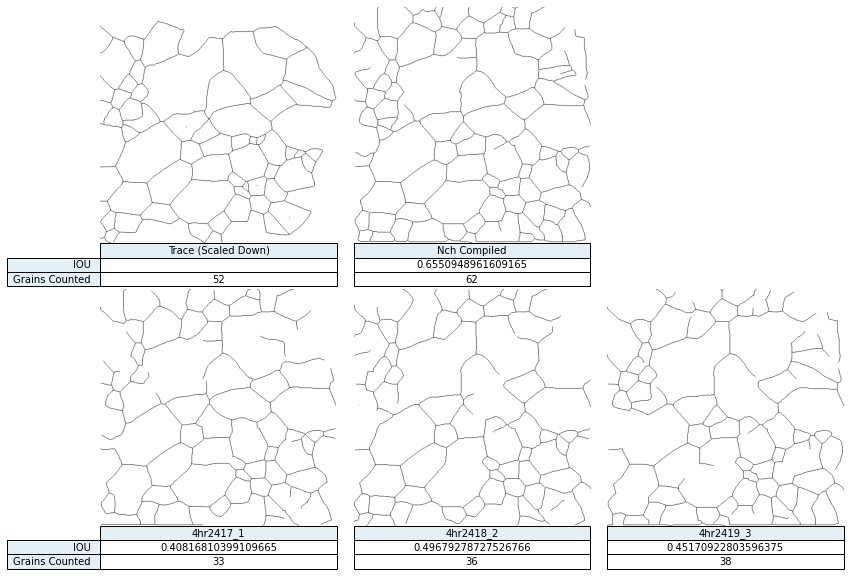

4hr2495


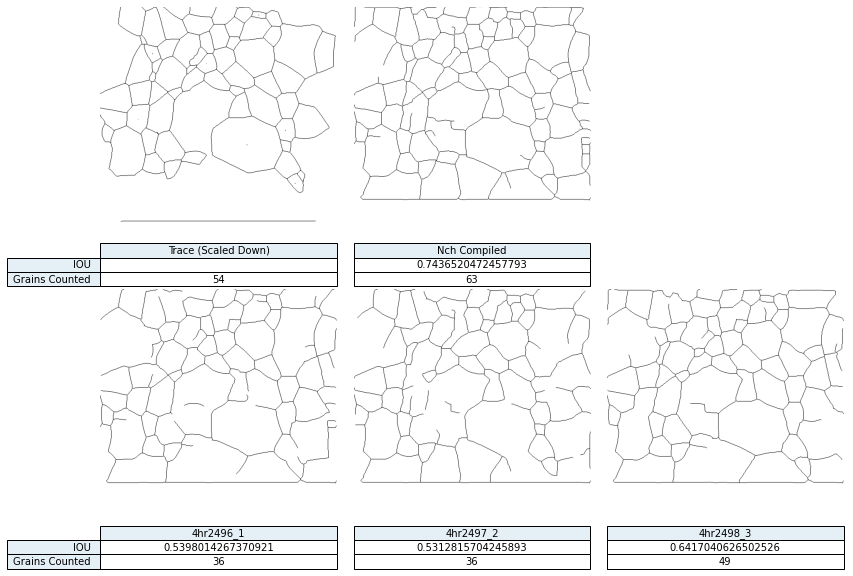

4hr2507


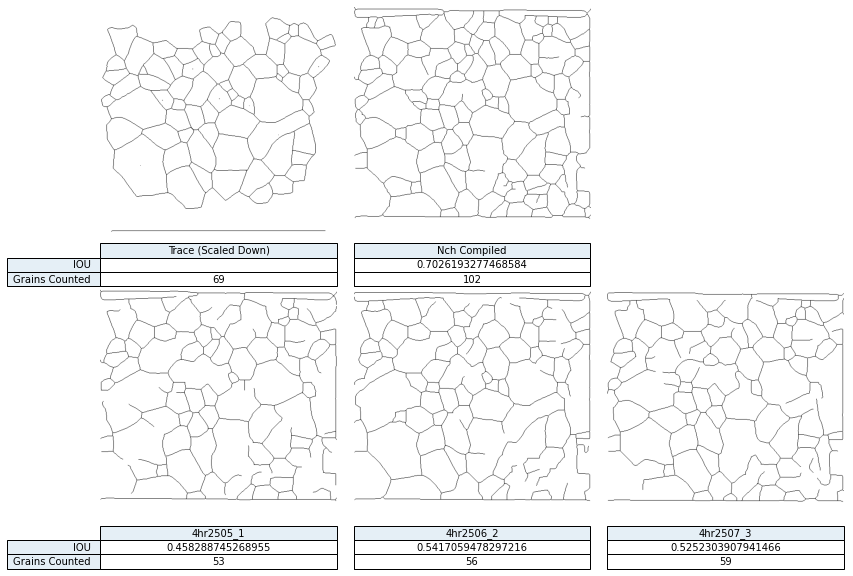

10hr2127


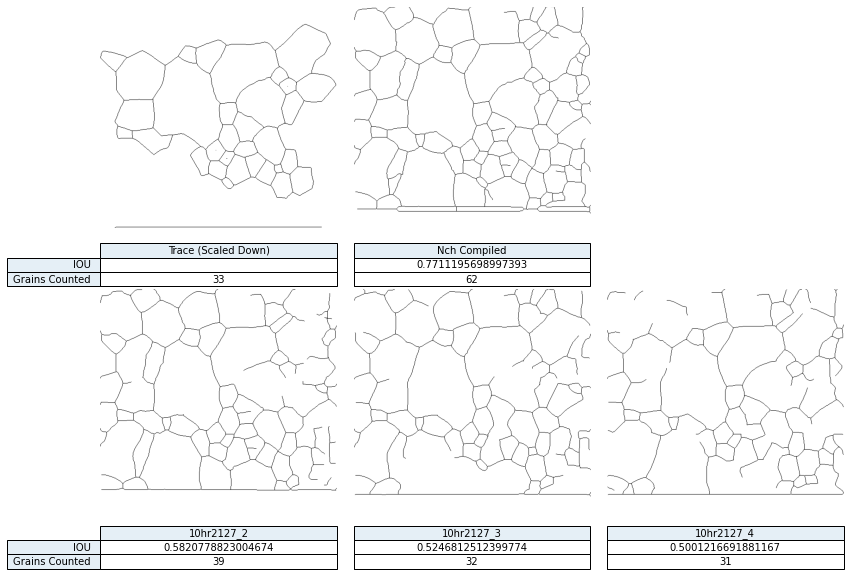

10hr2136


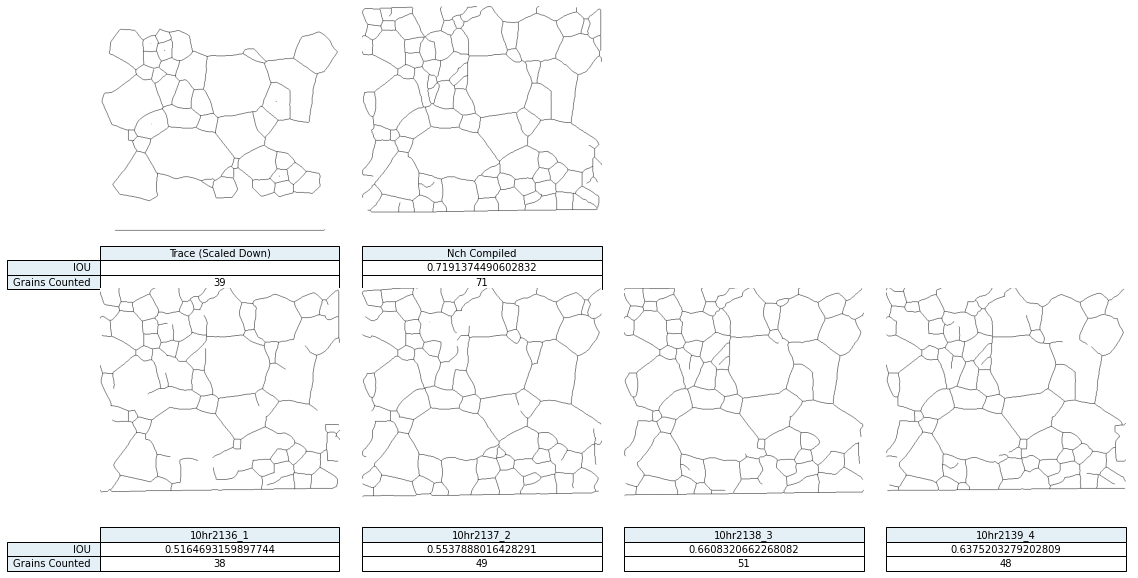

10hr2144


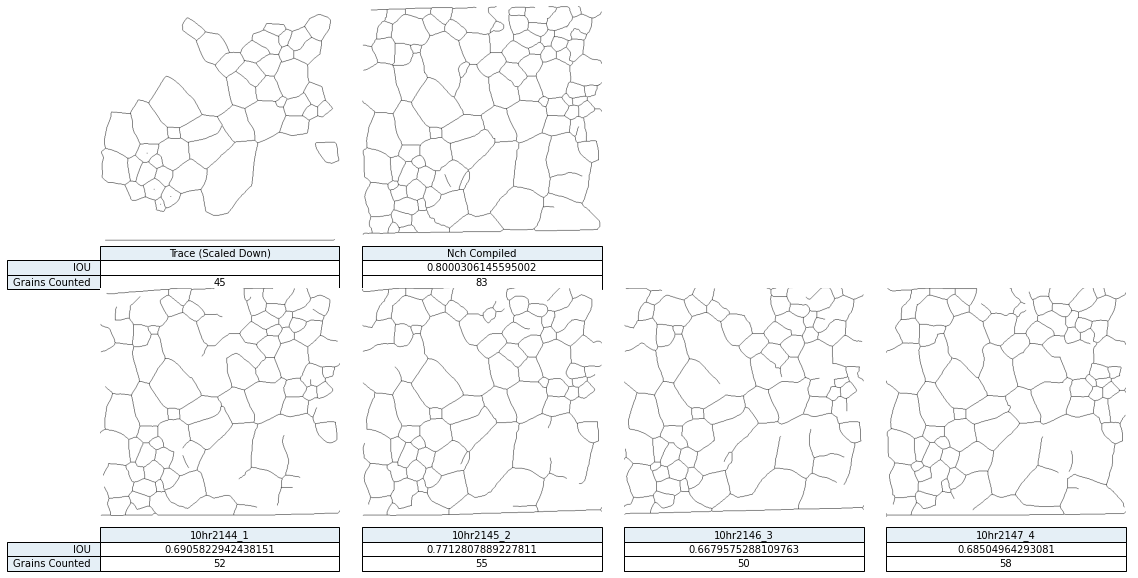

10hr2153


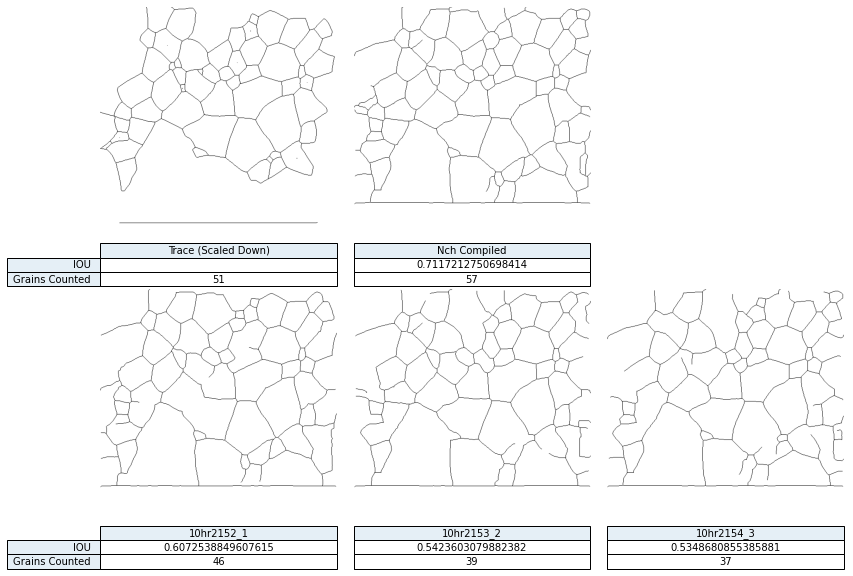

10hr2155
10hr2159


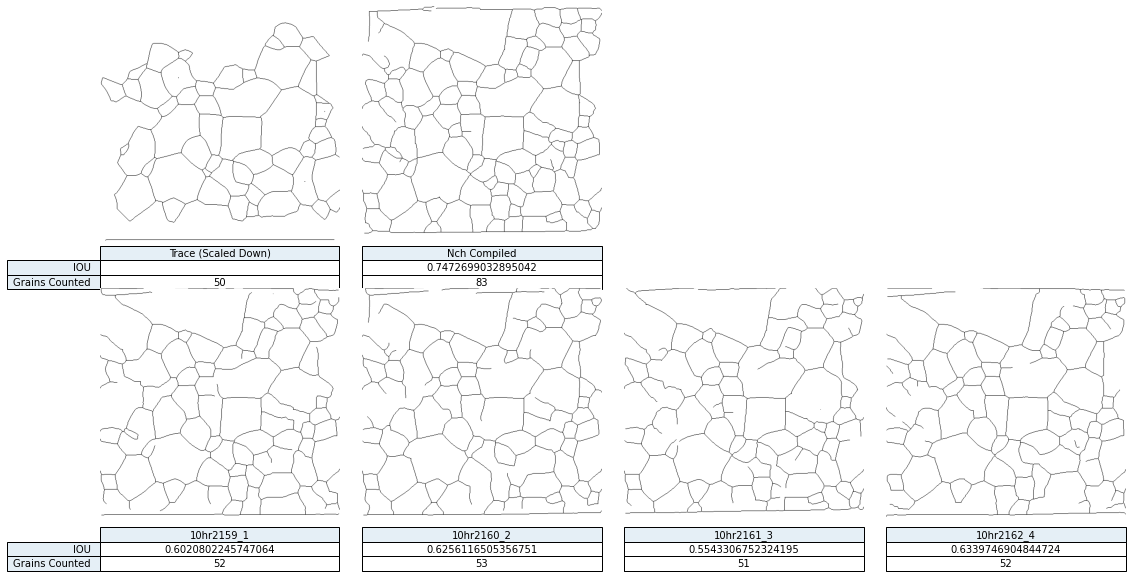

10hr2400


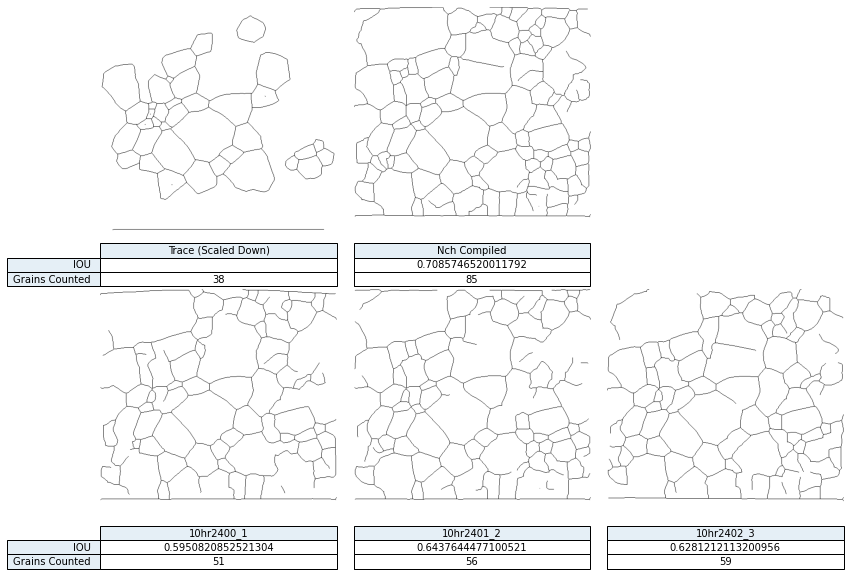

10hr2405


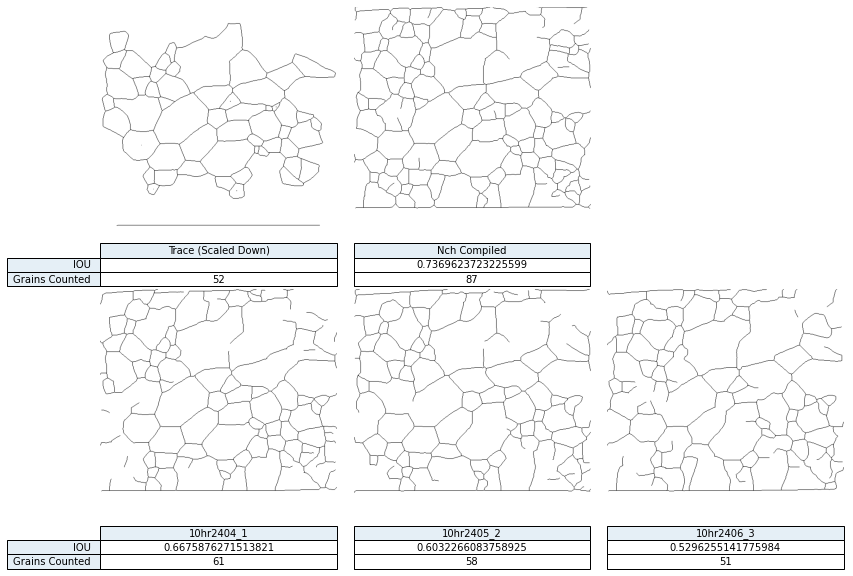

10hr2429


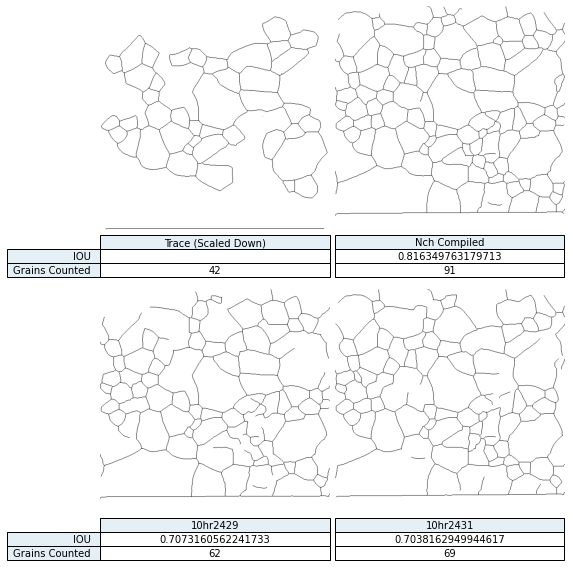

In [101]:
from src.post_process import post_process
from src.visual_tools import *
from src.utils.dilate_resize import dilate_resize
from src.analysis import find_iou, count_grains
import matplotlib.pyplot as plt
from skimage import img_as_ubyte as as_ubyte

md = ''

for entry in hours:
    print(entry)
    hour = entry.split('hr')[0] + 'HR'
    fov = entry.split('hr')[-1]
    fov_dir = f'../data/test_all/{hour}/{fov}'
    input_dir = os.path.join(fov_dir, 'results/tracings/')
    save_dir = os.path.join(fov_dir, 'slides/')
    
    imgs = []
    for fname in np.sort(os.listdir(input_dir)):
        if fname.endswith('.png'):
            path = os.path.join(input_dir, fname)
            img = io.imread(path)
            if len(img.shape) > 2:
                img = img[:,:,0]
            img = 1 - (img / np.max(img))
            imgs.append((img,path))
    
    if len(imgs) < 3: continue
    
    try:
        trace_path = os.path.join(fov_dir, 'trace.png')
        trace = io.imread(trace_path)
    except FileNotFoundError:
        trace_path = os.path.join(fov_dir, 'trace.tif')
        trace = io.imread(trace_path)
    if len(trace.shape) > 2:
        trace = trace[:,:,0]
    trace = 1 * (trace > 200)
    
    trace_scaled = dilate_resize(trace, imgs[0][0].shape, target_width=1, invert=True)
    trace_grains = count_grains(trace_scaled, thresh=0.5)
    
    fig, axes = plt.subplots(nrows=2, ncols=(len(imgs) - 1), figsize=(4 * (len(imgs) - 1), 8))

    for ax in axes.flatten():
        ax.set_axis_off()
    
    rcolors = plt.cm.BuPu(np.full(2, 0.1))
    ccolors = plt.cm.BuPu(np.full(1, 0.1))
    
    table_args = {
        'rowLoc':'right',
        'cellLoc': 'center',
        'loc': 'bottom',
        'colColours': ccolors,
        'rowColours': rcolors,
    }
    sub_plot(axes[0,0], trace_scaled)
    axes[0,0].table(cellText=([''],[str(trace_grains)]),rowLabels=['IOU','Grains Counted'], colLabels=(['Trace (Scaled Down)']), **table_args)

    for ind, img in enumerate(imgs):
        iou = find_iou(img[0], trace_scaled)
        n_grains = count_grains(img[0], thresh=0.5)
        title = img[1].split('/')[-1]
        title = title[:-4]
        if img[1].endswith('compiled.png'):
            sub_plot(axes[0,1], img[0])
            axes[0,1].table(cellText=([str(iou)],[str(n_grains)]),rowLabels=[None,None], colLabels=(['Nch Compiled']), **table_args)
        else:
            sub_plot(axes[1,ind], img[0])
            if ind == 0:
                axes[1,ind].table(cellText=([str(iou)],[str(n_grains)]),rowLabels=['IOU','Grains Counted'], colLabels=([title]), **table_args)
            else:
                axes[1,ind].table(cellText=([str(iou)],[str(n_grains)]),rowLabels=[None,None], colLabels=([title]), **table_args)
    
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir,'slide3.png'), 
            facecolor='white',
            bbox_inches='tight',
            dpi=300
           )
    plt.show()
    plt.close()
    
    md += generate_markdown(hour, fov, slides=['slide3.png'])

with open('../data/test_all/tmp.md', 'w') as f:
    f.write(md)